In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import numpy as np
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.preprocessing import image                  

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import regularizers
from tqdm import tqdm
import pandas as pd
import random

In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
dog_breeds = len(dog_names)


In [4]:
img_width, img_height = 224, 224

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
def ResNet50_predict_labels(img_path):

    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [6]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [6]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3   = bottleneck_features['train']
valid_InceptionV3   = bottleneck_features['valid']
test_InceptionV3    = bottleneck_features['test']

In [7]:
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
inception_model.add(Dropout(0.4))
inception_model.add(Dense(dog_breeds, activation='softmax'))

In [8]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [9]:
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

myModel = InceptionV3(weights='imagenet', include_top=False)

In [10]:
# myModel = InceptionV3(weights='imagenet', include_top=False)

In [11]:
# def extract_InceptionV3(tensor):
    
#     return myModel.predict(preprocess_input(tensor))

In [12]:
top_N = 4

def predict_breed(path):
    image_tensor = path_to_tensor(path)
    bottleneck_features = myModel.predict(preprocess_input(image_tensor))
    prediction = inception_model.predict(bottleneck_features)[0]
    breeds_predicted = [dog_names[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
    confidence_predicted = np.sort(prediction)[::-1][:top_N]
    return breeds_predicted, confidence_predicted
    

In [13]:
def make_prediction(path, multiple_breeds = False):
    breeds, confidence = predict_breed(path)
    img = mpimg.imread(path)
    plt.axis('off')


    if multiple_breeds:
        all_labs   = []
        all_scores = []
        for i, j in zip(breeds, confidence):
#             print(i.replace("_", " "))
            all_labs.append(i.replace("_", " "))
            all_scores.append(j)
    
    return all_labs, all_scores
        

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.54it/s]


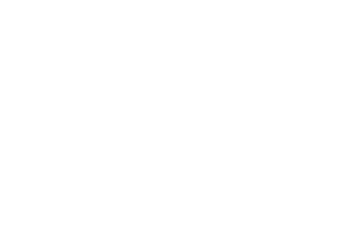

In [26]:
srcDir        = 'L_batchSize8_training_epoch5000_truncatedNormal'

allFiles      = os.listdir(srcDir)
random.shuffle(allFiles) 
all_fName     = []
all_A_name    = []
all_A_score   = []
all_B_name    = []
all_B_score   = []
all_C_name    = []
all_C_score   = []
all_D_name    = []
all_D_score   = []
all_Models    = []

cntr = 0
for thisFname in tqdm(allFiles):
    if thisFname.endswith('.png'):
#         if cntr >1:
#             break
        all_labs, all_scores = make_prediction(srcDir + os.sep + thisFname, multiple_breeds = True)
        all_fName.append(thisFname)
        all_A_name.append(all_labs[0])
        all_B_name.append(all_labs[1])
        all_C_name.append(all_labs[2])
        all_D_name.append(all_labs[3])

        all_A_score.append(all_scores[0])
        all_B_score.append(all_scores[1])
        all_C_score.append(all_scores[2])
        all_D_score.append(all_scores[3])
        all_Models.append('GAN_v1')
        cntr += 1

D_df = pd.DataFrame()

D_df['Model']        = all_Models
D_df['FName']        = all_fName
D_df['all_A_name']   = all_A_name
D_df['all_A_score']  = all_A_score
D_df['all_B_name']   = all_B_name
D_df['all_B_score']  = all_B_score
D_df['all_C_name']   = all_C_name
D_df['all_C_score']  = all_C_score
D_df['all_D_name']   = all_D_name
D_df['all_D_score']  = all_D_score

D_df.to_csv('L_batchSize8_training_epoch5000_truncatedNormal.csv',index=False) 

In [21]:
np.mean(D_df['all_A_score'].values)

0.2922598133049905

In [ ]:
srcDir        = 'S_Results_v2'

allFiles      = os.listdir(srcDir)
random.shuffle(allFiles) 
all_fName     = []
all_A_name    = []
all_A_score   = []
all_B_name    = []
all_B_score   = []
all_C_name    = []
all_C_score   = []
all_D_name    = []
all_D_score   = []
all_Models    = []

cntr = 0
for thisFname in tqdm(allFiles):
    if thisFname.endswith('.png'):
#         if cntr >1:
#             break
        all_labs, all_scores = make_prediction(srcDir + os.sep + thisFname, multiple_breeds = True)
        all_fName.append(thisFname)
        all_A_name.append(all_labs[0])
        all_B_name.append(all_labs[1])
        all_C_name.append(all_labs[2])
        all_D_name.append(all_labs[3])

        all_A_score.append(all_scores[0])
        all_B_score.append(all_scores[1])
        all_C_score.append(all_scores[2])
        all_D_score.append(all_scores[3])
        all_Models.append('CVAE_v1')
        cntr += 1

S_df = pd.DataFrame()

S_df['Model']        = all_Models
S_df['FName']        = all_fName
S_df['all_A_name']   = all_A_name
S_df['all_A_score']  = all_A_score
S_df['all_B_name']   = all_B_name
S_df['all_B_score']  = all_B_score
S_df['all_C_name']   = all_C_name
S_df['all_C_score']  = all_C_score
S_df['all_D_name']   = all_D_name
S_df['all_D_score']  = all_D_score

S_df.to_excel('CVAE_v2.xlsx',index=False) 

In [ ]:
np.mean(S_df['all_A_score'].values)

In [ ]:
srcDir        = 'D_Training'

allFiles      = os.listdir(srcDir)
random.shuffle(allFiles) 
all_fName     = []
all_A_name    = []
all_A_score   = []
all_B_name    = []
all_B_score   = []
all_C_name    = []
all_C_score   = []
all_D_name    = []
all_D_score   = []
all_Models    = []

cntr = 0
for thisFname in tqdm(allFiles):
    if thisFname.endswith('.png'):
#         if cntr >1:
#             break
        all_labs, all_scores = make_prediction(srcDir + os.sep + thisFname, multiple_breeds = True)
        all_fName.append(thisFname)
        all_A_name.append(all_labs[0])
        all_B_name.append(all_labs[1])
        all_C_name.append(all_labs[2])
        all_D_name.append(all_labs[3])

        all_A_score.append(all_scores[0])
        all_B_score.append(all_scores[1])
        all_C_score.append(all_scores[2])
        all_D_score.append(all_scores[3])
        all_Models.append('GAN_Train_Set')
        cntr += 1

DT_df = pd.DataFrame()

DT_df['Model']        = all_Models
DT_df['FName']        = all_fName
DT_df['all_A_name']   = all_A_name
DT_df['all_A_score']  = all_A_score
DT_df['all_B_name']   = all_B_name
DT_df['all_B_score']  = all_B_score
DT_df['all_C_name']   = all_C_name
DT_df['all_C_score']  = all_C_score
DT_df['all_D_name']   = all_D_name
DT_df['all_D_score']  = all_D_score

DT_df.to_excel('GAN_Train.xlsx',index=False) 

In [ ]:
np.mean(DT_df['all_A_score'].values)

In [ ]:
srcDir        = 'S_Training'

allFiles      = os.listdir(srcDir)
random.shuffle(allFiles) 
all_fName     = []
all_A_name    = []
all_A_score   = []
all_B_name    = []
all_B_score   = []
all_C_name    = []
all_C_score   = []
all_D_name    = []
all_D_score   = []
all_Models    = []

cntr = 0
for thisFname in tqdm(allFiles):
    if thisFname.endswith('.png'):
#         if cntr >1:
#             break
        all_labs, all_scores = make_prediction(srcDir + os.sep + thisFname, multiple_breeds = True)
        all_fName.append(thisFname)
        all_A_name.append(all_labs[0])
        all_B_name.append(all_labs[1])
        all_C_name.append(all_labs[2])
        all_D_name.append(all_labs[3])

        all_A_score.append(all_scores[0])
        all_B_score.append(all_scores[1])
        all_C_score.append(all_scores[2])
        all_D_score.append(all_scores[3])
        all_Models.append('CVAE_Train_Set')
        cntr += 1

ST_df = pd.DataFrame()

ST_df['Model']        = all_Models
ST_df['FName']        = all_fName
ST_df['all_A_name']   = all_A_name
ST_df['all_A_score']  = all_A_score
ST_df['all_B_name']   = all_B_name
ST_df['all_B_score']  = all_B_score
ST_df['all_C_name']   = all_C_name
ST_df['all_C_score']  = all_C_score
ST_df['all_D_name']   = all_D_name
ST_df['all_D_score']  = all_D_score

ST_df.to_excel('CVAE_Train.xlsx',index=False) 

In [ ]:
ST_df

In [ ]:
np.mean(ST_df['all_A_score'].values)

In [ ]:
srcDir        = 'Val_Results'

allFiles      = os.listdir(srcDir)
random.shuffle(allFiles) 
all_fName     = []
all_A_name    = []
all_A_score   = []
all_B_name    = []
all_B_score   = []
all_C_name    = []
all_C_score   = []
all_D_name    = []
all_D_score   = []
all_Models    = []

cntr = 0
for thisFname in tqdm(allFiles):
    if thisFname.endswith('.jpg'):
#         if cntr >1:
#             break
        all_labs, all_scores = make_prediction(srcDir + os.sep + thisFname, multiple_breeds = True)
        all_fName.append(thisFname)
        all_A_name.append(all_labs[0])
        all_B_name.append(all_labs[1])
        all_C_name.append(all_labs[2])
        all_D_name.append(all_labs[3])

        all_A_score.append(all_scores[0])
        all_B_score.append(all_scores[1])
        all_C_score.append(all_scores[2])
        all_D_score.append(all_scores[3])
        all_Models.append('GAN_v2')
        cntr += 1

ST_df = pd.DataFrame()

ST_df['Model']        = all_Models
ST_df['FName']        = all_fName
ST_df['all_A_name']   = all_A_name
ST_df['all_A_score']  = all_A_score
ST_df['all_B_name']   = all_B_name
ST_df['all_B_score']  = all_B_score
ST_df['all_C_name']   = all_C_name
ST_df['all_C_score']  = all_C_score
ST_df['all_D_name']   = all_D_name
ST_df['all_D_score']  = all_D_score

ST_df.to_excel('Val_Results.xlsx',index=False) 

In [ ]:
np.mean(ST_df['all_A_score'].values)